In [ ]:
!pip install pyspark

In [ ]:

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
!wget https://www.dropbox.com/s/jh8e8mo5x4dg4ia/USvideos.csv #https://www.dropbox.com/s/i6heazqtoo26rvm/youtube_videos.csv

In [ ]:
from pyspark.sql.types import *

youtube_schema=StructType([
    StructField("video_id", StringType(), True),
    StructField("trending_date", StringType(), True),
    StructField("title", StringType(), True),
    StructField("channel_title", StringType(), True),
    StructField("category_id", IntegerType(), True),
    StructField("publish_time", StringType(), True),
    StructField("tags", StringType(), True),
    StructField("views", IntegerType(), True),
    StructField("likes", IntegerType(), True),
    StructField("dislikes", IntegerType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("thumbnail_link", StringType(), True),
    StructField("comments_disabled", StringType(), True),
    StructField("ratings_disabled", StringType(), True),
    StructField("video_error_or_removed", StringType(), True),
    StructField("description", StringType(), True)

])


In [ ]:
youtube_schema

StructType(List(StructField(video_id,StringType,true),StructField(trending_date,StringType,true),StructField(title,StringType,true),StructField(channel_title,StringType,true),StructField(category_id,IntegerType,true),StructField(publish_time,StringType,true),StructField(tags,StringType,true),StructField(views,IntegerType,true),StructField(likes,IntegerType,true),StructField(dislikes,IntegerType,true),StructField(comment_count,IntegerType,true),StructField(thumbnail_link,StringType,true),StructField(comments_disabled,StringType,true),StructField(ratings_disabled,StringType,true),StructField(video_error_or_removed,StringType,true),StructField(description,StringType,true)))

In [ ]:
df_youtube = spark.read.csv(path='USvideos.csv', sep=',', header = True, schema = youtube_schema,mode="DROPMALFORMED")

In [ ]:
df_youtube.count()

48137

In [ ]:
# Explore data :
# 1. show the first 5 rows
# 2. print schema

df_youtube.show(5,False)
df_youtube.printSchema()

+-----------+-------------+--------------------------------------------------------------+---------------------+-----------+------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+--------+-------------+----------------------------------------------+-----------------+----------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#show the statistcs of each column
df_youtube.describe().show()

+-------+-----------+-------------+--------------------+------------------------+-----------------+--------------------+--------------------+------------------+------------------+-----------------+------------------+--------------------+-----------------+----------------+----------------------+--------------------+
|summary|   video_id|trending_date|               title|           channel_title|      category_id|        publish_time|                tags|             views|             likes|         dislikes|     comment_count|      thumbnail_link|comments_disabled|ratings_disabled|video_error_or_removed|         description|
+-------+-----------+-------------+--------------------+------------------------+-----------------+--------------------+--------------------+------------------+------------------+-----------------+------------------+--------------------+-----------------+----------------+----------------------+--------------------+
|  count|      40949|        40949|              

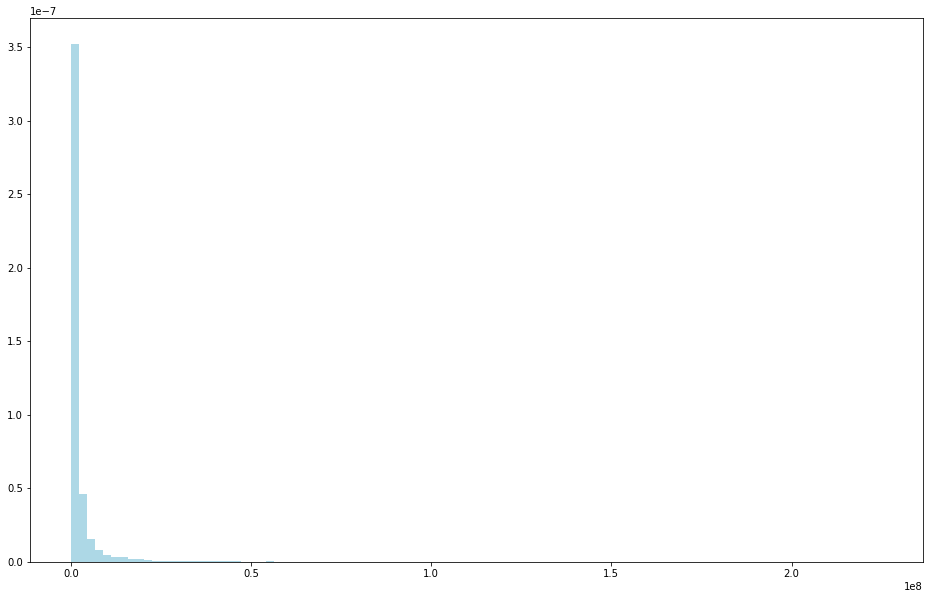

In [ ]:
import matplotlib.pyplot as plt

targets = df_youtube.rdd.map(lambda x:float(x['views'])).collect()
#targets = df_youtube.filter(df_youtube.views < 20000000).rdd.map(lambda x:float(x['views'])).collect()


plt.hist(targets, bins=100, color='lightblue', density=True)
fig = plt.gcf()
fig.set_size_inches(16, 10) 

In [ ]:
#show correlation between numeric columns

for i in df_youtube.columns[7:11]:
  for j in df_youtube.columns[7:11]:
    if i!=j : print(f'Correlation between  {i} and {j} : %g' % df_youtube.stat.corr(i,j))

Correlation between  views and likes : 0.851442
Correlation between  views and dislikes : 0.474106
Correlation between  views and comment_count : 0.621245
Correlation between  likes and views : 0.851442
Correlation between  likes and dislikes : 0.449287
Correlation between  likes and comment_count : 0.804596
Correlation between  dislikes and views : 0.474106
Correlation between  dislikes and likes : 0.449287
Correlation between  dislikes and comment_count : 0.700965
Correlation between  comment_count and views : 0.621245
Correlation between  comment_count and likes : 0.804596
Correlation between  comment_count and dislikes : 0.700965


In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

#We can also compute the correlation matrix and show the heatmap for it

col_names = df_youtube.columns[7:11]
features = df_youtube.rdd.map(lambda row: row[7:11])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                  views     likes  dislikes  comment_count
views          1.000000  0.849177  0.472213       0.617621
likes          0.849177  1.000000  0.447186       0.803057
dislikes       0.472213  0.447186  1.000000       0.700184
comment_count  0.617621  0.803057  0.700184       1.000000


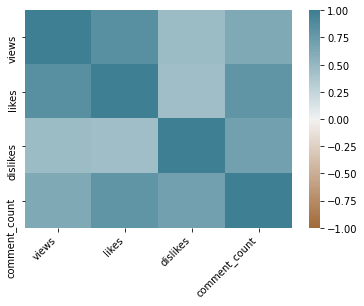

In [ ]:
import seaborn as sns

ax = sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(40, 220, n=220)
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

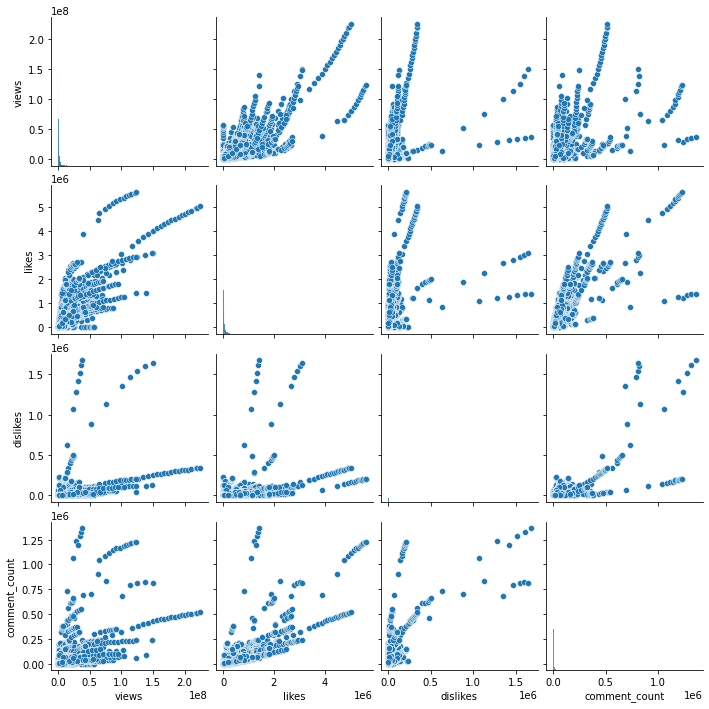

In [ ]:
df = df_youtube.select(df_youtube.columns[7:11]).toPandas()
xs = sns.pairplot(df)

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Prepare data for linear regression
# For the prediction, we will only use the following variables : category_id, likes, dislikes, comment_count

vectorAssembler = VectorAssembler(inputCols = ['likes', 'dislikes', 'comment_count'], outputCol = 'features')
#vectorAssembler = VectorAssembler(inputCols = ['likes', 'comment_count'], outputCol = 'features')
vdf_youtube = vectorAssembler.transform(df_youtube)

#vdf_youtube.show(1000)

# The linear regression only needs 2 columns : 'features', which is the values of all the independent variables and the target var 'views' 
#vdf_youtube = vdf_youtube.select('features', 'views')

In [ ]:
vdf_youtube.show(5,False)

+-----------+-------------+--------------------------------------------------------------+---------------------+-----------+------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+------+--------+-------------+----------------------------------------------+-----------------+----------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
vdf_youtube1 = vdf_youtube.select('features', 'views')

In [ ]:
# Split the data into training and testing set. We use 70% for training and 30% testing 

train_df, test_df = vdf_youtube.randomSplit([0.7, 0.3])
train_df = train_df.select('features', 'views')
test_df = test_df.select('features', 'views')

train_df.show(5)
test_df.show(5)

+--------------------+------+
|            features| views|
+--------------------+------+
|  [4429.0,54.0,94.0]|563746|
|[7407.0,209.0,831.0]|218227|
|[5214.0,108.0,516.0]|129360|
|[6950.0,184.0,735.0]|198315|
|   [453.0,26.0,19.0]| 69786|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| views|
+--------------------+------+
|[7734.0,212.0,846.0]|231341|
|   [438.0,23.0,23.0]| 67429|
|   [460.0,27.0,20.0]| 71089|
|[3788.0,603.0,309...|291653|
|[11655.0,348.0,66...|900722|
+--------------------+------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import LinearRegression

# Train the model

lr = LinearRegression(featuresCol = 'features', labelCol='views', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [32.29079799826464,74.39161313022275,-72.75502812475015]
Intercept: 288662.0085760916


In [ ]:
# show the model summary 

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


RMSE: 3539708.572215
r2: 0.778807


In [ ]:
train_df.describe().show()

+-------+-----------------+
|summary|            views|
+-------+-----------------+
|  count|            28686|
|   mean|2379320.533779544|
| stddev|7526428.753016577|
|    min|              549|
|    max|        220490543|
+-------+-----------------+



In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","views","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="views",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------+--------------------+
|        prediction| views|            features|
+------------------+------+--------------------+
| 492619.3084847389|231341|[7734.0,212.0,846.0]|
| 302843.0195544574| 67429|   [438.0,23.0,23.0]|
| 304069.2486473144| 71089|   [460.0,27.0,20.0]|
|230806.39212119015|291653|[3788.0,603.0,309...|
| 642226.4267997256|900722|[11655.0,348.0,66...|
+------------------+------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.780359


In [ ]:
# Predict on test data

test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 3.31565e+06


In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5, 0.3895690880014757, 0.2354627728914711, 0.18687087612610426, 0.16667226794144896, 0.15519162300325867, 0.14318846588535572, 0.13400362499882965, 0.12456198636649621, 0.11734958986327518, 0.11059677741715361]
+-------------------+
|          residuals|
+-------------------+
| 134889.87262428878|
|  -264701.368121787|
|-298158.92904473643|
| -274981.1658083005|
|-234055.57647632103|
|-148214.25661765234|
| 102409.51367474475|
|  283023.2810372863|
|  351829.3724666366|
| -1721864.840070162|
|-1765871.3191107484|
|-1788953.9398023644|
|-1778973.7170080328|
|-1727409.4926585034|
| -1645110.063364232|
| -285863.5901720881|
| -285739.5901720881|
| -285674.5901720881|
| -285615.5901720881|
| -285596.5901720881|
+-------------------+
only showing top 20 rows



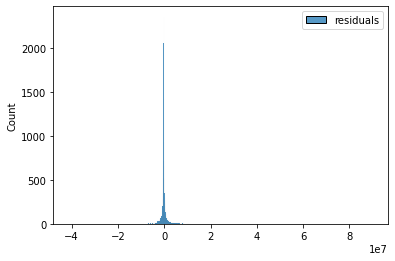

In [ ]:
res1 = trainingSummary.residuals.toPandas()
ax = sns.histplot(res1)

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","views","features").show()

+------------------+--------+--------------------+
|        prediction|   views|            features|
+------------------+--------+--------------------+
| 492619.3084847389|  231341|[7734.0,212.0,846.0]|
| 302843.0195544574|   67429|   [438.0,23.0,23.0]|
| 304069.2486473144|   71089|   [460.0,27.0,20.0]|
|230806.39212119015|  291653|[3788.0,603.0,309...|
| 642226.4267997256|  900722|[11655.0,348.0,66...|
| 2894191.128746573| 1103258|[94195.0,1017.0,7...|
| 3942585.998285331| 2425578|[129381.0,1522.0,...|
| 288726.5901720881|    3085|       [2.0,0.0,0.0]|
| 586054.0472075272|  262592|[10639.0,386.0,10...|
|  4253806.34098276| 1124080|[132482.0,1848.0,...|
| 947890.6221787522|  518719|[22962.0,566.0,17...|
|1583420.4457347065| 2187248|[56040.0,976.0,80...|
|1676068.7549343866| 2620061|[59416.0,1201.0,8...|
| 782092.2242435287| 1371506|[18997.0,1185.0,2...|
| 289408.3005498745|  481259|  [431.0,43.0,225.0]|
|1112925.4872077794| 1036037|[30610.0,1231.0,3...|
| 755925.3061706306|  686367|[1